In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.8/512.8 kB 776.1 kB/s eta 0:00:00


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics
import timm

from torch.utils.data import DataLoader

import os
import sys
import glob
import pathlib

import re
import math
import random
import numpy as np
import pandas as pd

from typing import Callable, Dict, Optional, Tuple

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.composition import Compose, OneOf

import cv2

print(f'Pytorch version: {torch.__version__}')
print(f'PyTorch Lightning version: {pl.__version__}')
print(f'Albumentations version: {A.__version__}')
print(f'Timm version: {timm.__version__}')
print(f'Python version: P{sys.version}')

Pytorch version: 1.11.0
PyTorch Lightning version: 1.6.4
Albumentations version: 1.2.0
Timm version: 0.6.5
Python version: P3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Config

In [4]:
class CFG:
    model_name = 'tf_efficientnet_b5_ns'
    pretrained = True
    num_classes = 0

    image_size = 512
    crop_size = 0.9
    fold = 0
    n_splits = 5
    
    num_epochs = 25
    batch_size = 32
    
    embedding_size = 128
    s = 30
    m = 0.5
    
    lr = 1e-4
    max_lr = 2e-3
    weight_decay = 1e-6
    
    precision = 16
    num_workers = 4
    seed = 42
    
    steps_per_epoch = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## CSV Preparation

In [5]:
TRAIN_DIR = "../input/paddy-disease-classification/train_images/"

def process(data):
    path=pathlib.Path(data)
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
    df1=pd.Series(filepaths,name='file_path').astype(str)
    df2=pd.Series(labels,name='label')
    df=pd.concat([df1,df2],axis=1)
    
    return df

In [6]:
df = process(TRAIN_DIR)
df['image_id'] = df['file_path'].apply(lambda image:image.split('/')[-1])
df.head()

,file_path,label,image_id
0,../input/paddy-disease-classification/train_im...,tungro,109629.jpg
1,../input/paddy-disease-classification/train_im...,tungro,104765.jpg
2,../input/paddy-disease-classification/train_im...,tungro,109706.jpg
3,../input/paddy-disease-classification/train_im...,tungro,100098.jpg
4,../input/paddy-disease-classification/train_im...,tungro,102734.jpg


In [7]:
num_classes  = df['label'].nunique()
print(f'num_classes : {num_classes}')

CFG.num_classes = num_classes

num_classes : 10


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

encoder = LabelEncoder()
label2index = {l: i for (i, l) in enumerate(encoder.fit(df["label"]).classes_)}
index2label = {x[1]: x[0] for x in label2index.items()}

df["label_index"] = encoder.fit_transform(df["label"])

skf = StratifiedKFold(n_splits=CFG.n_splits)
for fold, (_, val_) in enumerate(skf.split(X=df, y=df.label)):
    df.loc[val_, "fold"] = fold

df.head()

,file_path,label,image_id,label_index,fold
0,../input/paddy-disease-classification/train_im...,tungro,109629.jpg,9,0.0
1,../input/paddy-disease-classification/train_im...,tungro,104765.jpg,9,0.0
2,../input/paddy-disease-classification/train_im...,tungro,109706.jpg,9,0.0
3,../input/paddy-disease-classification/train_im...,tungro,100098.jpg,9,0.0
4,../input/paddy-disease-classification/train_im...,tungro,102734.jpg,9,0.0


In [9]:
TEST_DIR = "../input/paddy-disease-classification/test_images/" 

test_df = pd.read_csv("../input/paddy-disease-classification/sample_submission.csv")
test_df["file_path"] = test_df["image_id"].apply(lambda image: TEST_DIR + image)
test_df['label'] = -1
test_df["label_index"] = -1
test_df.head()

,image_id,label,file_path,label_index
0,200001.jpg,-1,../input/paddy-disease-classification/test_ima...,-1
1,200002.jpg,-1,../input/paddy-disease-classification/test_ima...,-1
2,200003.jpg,-1,../input/paddy-disease-classification/test_ima...,-1
3,200004.jpg,-1,../input/paddy-disease-classification/test_ima...,-1
4,200005.jpg,-1,../input/paddy-disease-classification/test_ima...,-1


In [10]:
tmp = np.sqrt(1 / np.sqrt(df["label_index"].value_counts().sort_index().values))
df_margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 0.3 + 0.05

## Dataset

In [11]:
class VisionDataset(torch.utils.data.Dataset):
    def __init__(self, df_, transforms=None, test=False):
        self.image_path = df_['file_path'].values
        self.labels = df_["label_index"].values
        self.ids = df_['image_id']
        self.transforms = transforms
        self.test = test

    def __len__(self):
        return len(self.image_path)
    
    def resize(self, image, interp):
        return  cv2.resize(image, (CFG.image_size, CFG.image_size), interpolation=interp)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        label = self.labels[index]
        image_id = self.ids[index]
        
        image_path = self.image_path[index]
        image = cv2.imread(image_path, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.resize(image, cv2.INTER_AREA)
        
        if self.transforms is not None:
            result = self.transforms(image=image)
            image = result['image']
        
        if self.test:
            return {'image':image, 'target': image_id}
        else:
            return {'image':image, 'target': label}

## Lightning DataModule

In [12]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.df = df
        self.test_df = test_df
        self.train_transforms, self.valid_transform = self.init_transforms()
        

    def init_transforms(self):
        crop_size = round(CFG.image_size*CFG.crop_size)
        train_transforms = Compose([
            A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            A.Affine(rotate=(-15, 15), translate_percent=(0.0, 0.25), shear=(-3, 3), p=0.7),
            A.Cutout(max_h_size=int(crop_size * 0.4), max_w_size=int(crop_size * 0.4), num_holes=1, p=0.5),
            A.RandomGridShuffle(grid=(2, 2), p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.05),
            A.RandomSnow(p=0.05),
            A.RandomRain(p=0.05),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
        ])
        
        valid_transform = Compose([
            A.CenterCrop(height=crop_size, width=crop_size, always_apply=True),
            A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
        ])
            
        return train_transforms, valid_transform
        

    def setup(self, stage: Optional[str] = None):
        
        if stage == "fit" or stage is None:
            train_df = self.df[self.df.fold%CFG.n_splits != CFG.fold].reset_index(drop=True)
            val_df = self.df[self.df.fold%CFG.n_splits == CFG.fold].reset_index(drop=True)
        
            self.train_dataset = VisionDataset(train_df, transforms=self.train_transforms)
            self.valid_dataset = VisionDataset(val_df, transforms=self.valid_transform)
            
            self.test_dataset = VisionDataset(self.test_df, transforms=self.valid_transform, test=True)
   

    def train_dataloader(self) -> DataLoader:
        return self.dataloader(self.train_dataset, train=True)


    def val_dataloader(self) -> DataLoader:
        return self.dataloader(self.valid_dataset)
    
    def test_dataloader(self) -> DataLoader:
        return self.dataloader(self.test_dataset)
    

    def dataloader(self, dataset: VisionDataset, train: bool = False) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=CFG.batch_size,
            shuffle=train,
            num_workers=CFG.num_workers,
            pin_memory=True,
            drop_last=train,
        )

## ArcMarginProduct

In [13]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta + m)
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float,
        m: float,
        easy_margin: bool,
        ls_eps: float,
    ):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input: torch.Tensor, label: torch.Tensor, device: str = "cuda") -> torch.Tensor:
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        # Enable 16 bit precision
        cosine = cosine.to(torch.float32)

        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [14]:
class DenseCrossEntropy(nn.Module):
    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
    def forward(self, x, target):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()

class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=1):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine   
    

class ArcFaceLossAdaptiveMargin(nn.modules.Module):
    def __init__(self, margins, n_classes, s=30.0):
        super().__init__()
        self.crit = DenseCrossEntropy()
        self.s = s
        self.margins = margins
        self.out_dim = n_classes
            
    def forward(self, logits, labels):
        ms = []
        ms = self.margins[labels.cpu().numpy()]
        cos_m = torch.from_numpy(np.cos(ms)).float().cuda()
        sin_m = torch.from_numpy(np.sin(ms)).float().cuda()
        th = torch.from_numpy(np.cos(math.pi - ms)).float().cuda()
        mm = torch.from_numpy(np.sin(math.pi - ms) * ms).float().cuda()
        labels = F.one_hot(labels, self.out_dim).float()
        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * cos_m.view(-1,1) - sine * sin_m.view(-1,1)
        phi = torch.where(cosine > th.view(-1,1), phi, cosine - mm.view(-1,1))
        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = self.crit(output, labels)
        return loss

## Lightning Module

In [15]:
class LitModule(pl.LightningModule):
    def __init__(self, model_name='tf_efficientnet_b0_ns', pretrained=True):
        super(LitModule, self).__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        
        self.multiple_dropout = [nn.Dropout(0.25) for i in range(8)]
        self.embedding = nn.Linear(in_features * 2, CFG.embedding_size)
        #self.fc = ArcMarginProduct(
        #    in_features=CFG.embedding_size,
        #    out_features=CFG.num_classes,
        #    s=CFG.s,
        #    m=CFG.m,
        #    easy_margin=False,
        #    ls_eps=0,
        #)
        
        self.fc = ArcMarginProduct_subcenter(
            in_features=CFG.embedding_size, 
            out_features=CFG.num_classes,)

        self.accuracy = torchmetrics.Accuracy(num_classes=CFG.num_classes)
    
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = ArcFaceLossAdaptiveMargin(
            margins=df_margins,
            n_classes=CFG.num_classes,
            s=CFG.s
        )
        self.lr = CFG.lr
        self.weight_decay = CFG.weight_decay
        
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        features = self.model(images)
        pooled_features_avg = nn.AdaptiveAvgPool2d(output_size=(1, 1))(features)
        pooled_features_max = nn.AdaptiveMaxPool2d(output_size=(1, 1))(features)
        pooled_features = torch.cat([pooled_features_avg, pooled_features_max], dim=1).flatten(1)
        pooled_features_dropout = torch.zeros((pooled_features.shape), device=self.device)
        for i in range(8):
            pooled_features_dropout += self.multiple_dropout[i](pooled_features)
        pooled_features_dropout /= 8
        embeddings = self.embedding(pooled_features_dropout)
        return embeddings

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, 
                                                             epochs=CFG.num_epochs, 
                                                             steps_per_epoch=CFG.steps_per_epoch,
                                                             max_lr=CFG.max_lr, 
                                                             pct_start=0.2, 
                                                             div_factor=1.0e+3, 
                                                             final_div_factor=1.0e+3)
        scheduler = {'scheduler': self.scheduler, 'interval': 'step',}
        return [self.optimizer], [scheduler]

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        images = batch['image']
        targets = batch['target'].long()
        
        embeddings = self(images)
        # For ArcMarginProduct
        #outputs = self.fc(embeddings, targets, self.device)
        outputs = self.fc(embeddings)
        
        # For ArcMarginProduct
        #loss = self.criterion(outputs)
        loss = self.criterion(outputs, targets)
        accuracy = self.accuracy(outputs.argmax(1), targets)
        
        logs = {'train_loss': loss, 'train_acc': accuracy, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        images = batch['image']
        targets = batch['target'].long()
        
        embeddings = self(images)
        # For ArcMarginProduct
        #outputs = self.fc(embeddings, targets, self.device)
        outputs = self.fc(embeddings)
        
        # For ArcMarginProduct
        #loss = self.criterion(outputs)
        loss = self.criterion(outputs, targets)
        accuracy = self.accuracy(outputs.argmax(1), targets)
        
        logs = {'valid_loss': loss, 'valid_acc': accuracy}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path, device):
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

## Train

In [16]:
def train():
    pl.seed_everything(CFG.seed)
    
    datamodule = LitDataModule()
    datamodule.setup()
    CFG.steps_per_epoch = len(datamodule.train_dataloader())
    
    module = LitModule()
    
    logger = pl.loggers.CSVLogger(save_dir='logs/', name=CFG.model_name)
    logger.log_hyperparams(CFG.__dict__)

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='valid_loss',
        save_top_k=1,
        save_last=True,
        save_weights_only=True,
        filename='{epoch:02d}-{valid_loss:.4f}-{valid_acc:.4f}',
        verbose=False,
        mode='min'
    )
    
    trainer = pl.Trainer(
        max_epochs=CFG.num_epochs,
        gpus=[0],
        accumulate_grad_batches=1,
        precision=CFG.precision,
        callbacks=[checkpoint_callback],
        logger=logger,
        weights_summary='top',
    )
    
    trainer.fit(module, datamodule=datamodule)
    
    return trainer

In [17]:
trainer = train()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Train Results

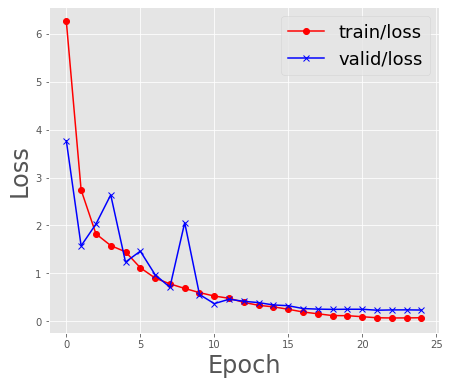

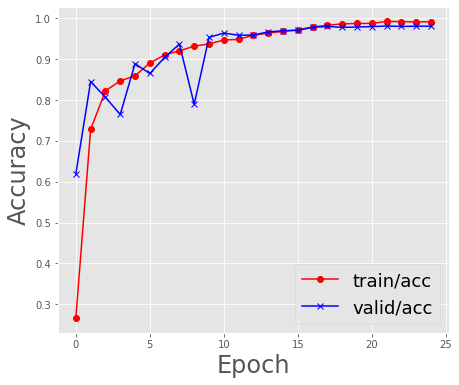

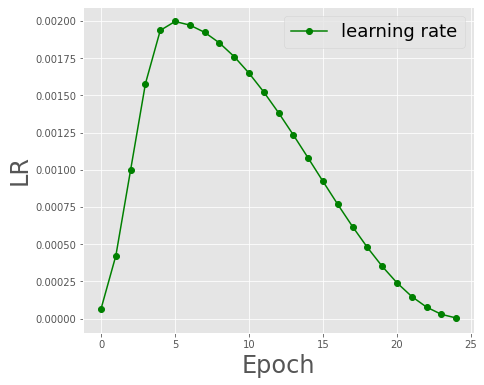

In [18]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_loss, color="r", marker="o", label='train/loss')
plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')

train_acc = metrics['train_acc'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop=True)
    
fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_acc, color="r", marker="o", label='train/acc')
plt.plot(valid_acc, color="b", marker="x", label='valid/acc')
plt.ylabel('Accuracy', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/acc.png')

lr = metrics['lr'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(lr, color="g", marker="o", label='learning rate')
plt.ylabel('LR', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/lr.png')

## Prediction

In [19]:
@torch.no_grad()
def infer(path):
    pl.seed_everything(CFG.seed)
    
    datamodule = LitDataModule()
    datamodule.setup()
    test_dataloader = datamodule.test_dataloader()
    
    module = LitModule.load_eval_checkpoint(path, device=CFG.device)
    
    image_ids = []
    prediction_list = []
    
    for batch in tqdm(test_dataloader):
        images = batch["image"].to(CFG.device, dtype=torch.float)
        ids = batch['target']
        embeddings = module(images)
        outputs = nn.Softmax(dim=1)(CFG.s * F.linear(F.normalize(embeddings), F.normalize(module.fc.weight)))
        preds = outputs.argmax(1).cpu().numpy()
        for pred in preds:
            prediction_list.append(index2label[pred])
        image_ids.extend(ids)
        
    prediction_df = pd.DataFrame({'image_id': image_ids, 'label': prediction_list})
    prediction_df.to_csv('submission.csv', index=False)

    return prediction_df

In [20]:
path = trainer.checkpoint_callback.best_model_path
#path = trainer.checkpoint_callback.last_model_path

submission_df = infer(path)
submission_df.head()

  0%|          | 0/109 [00:00<?, ?it/s]

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
